In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import cv2

import numpy as np

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
    

In [3]:
def load_image(path):
  if (os.path.exists(path)):
    # read the image using torchvision and convert it to tensor because the model expects a tensor
    img = torchvision.io.read_image("dog.jpg")
    print("Tensor shape: ", img.shape)
    plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
    return img
  else:
    print("File not found")
    return None


def normalize_image(image):
  original_image = image.shape
  scaler = preprocessing.MinMaxScaler()
  image = image.reshape(-1, 1)
  scaler.fit(image)
  scaled_image = scaler.transform(image).reshape(original_image)
  return scaled_image


def crop_image(image, crop_size, start_x, start_y):  # requires a torch image
  cropped_image = torchvision.transforms.functional.crop(
      image.cpu(), start_x, start_y, crop_size, crop_size)
  print("Cropped image shape: ", cropped_image.shape)
  plt.imshow(rearrange(cropped_image, 'c h w -> h w c').cpu().numpy())
  return cropped_image

Tensor shape:  torch.Size([3, 1365, 2048])
Cropped image shape:  torch.Size([3, 400, 400])


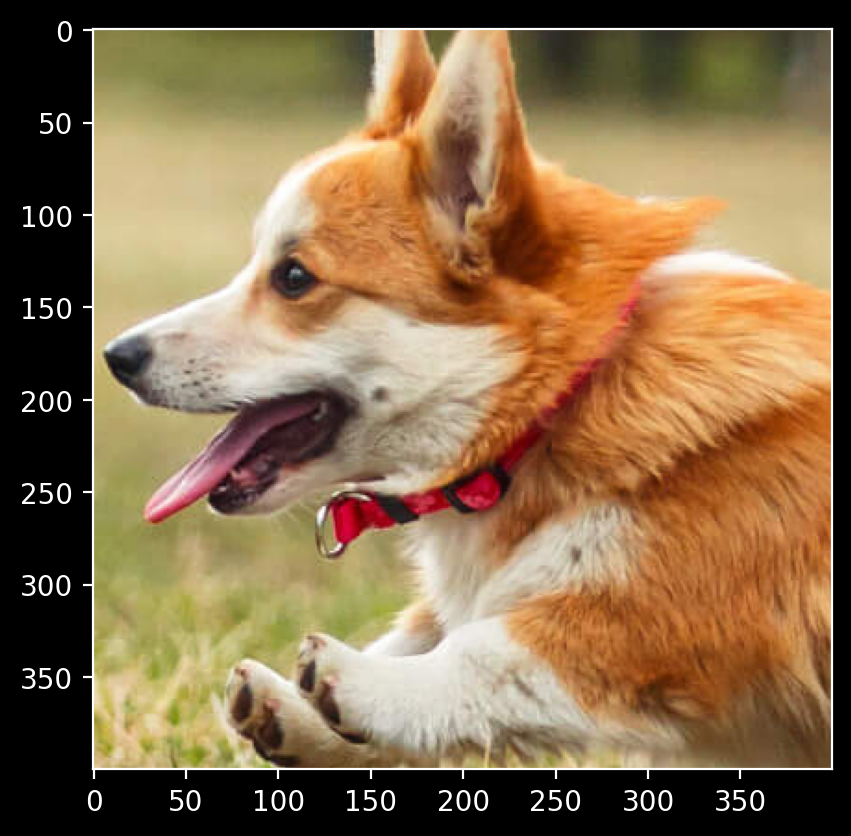

In [4]:
image_path = "dog.jpg"
image = load_image(image_path)

normalized_image = normalize_image(image)
torch_image = torch.tensor(normalized_image)
cropped_image = crop_image(torch_image, 400, 550, 800)

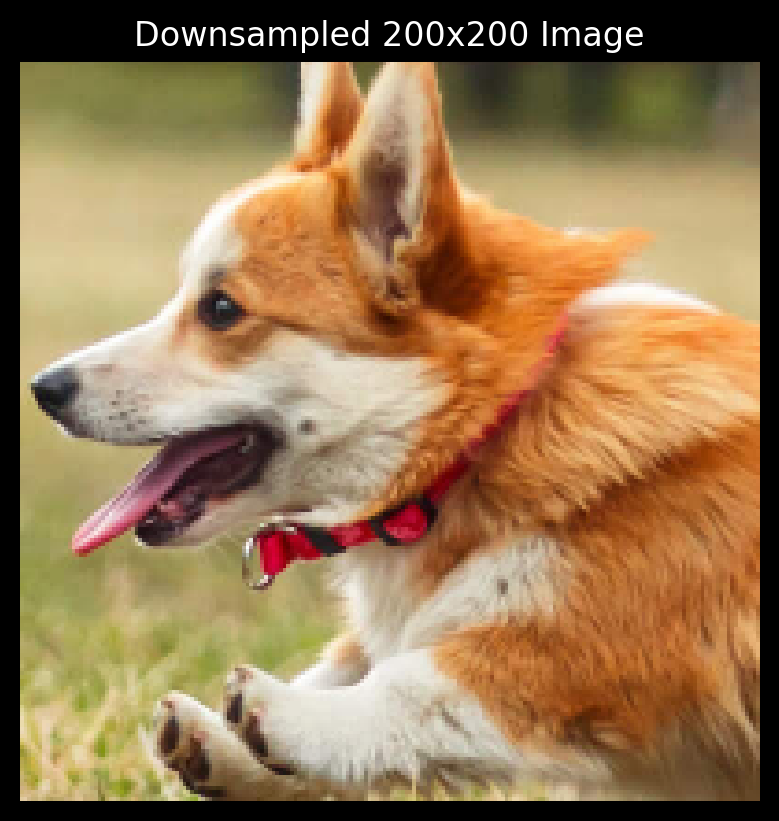

In [5]:
# Resize the image to 200x200
low_res_image = cv2.resize(rearrange(cropped_image.cpu().numpy(
), 'c h w -> h w c'), (200, 200), interpolation=cv2.INTER_LINEAR)
low_res_image = torch.tensor(
    rearrange(low_res_image, 'h w c -> c h w')).to(device)

plt.imshow(rearrange(low_res_image.cpu(), 'c h w -> h w c').numpy())
plt.title('Downsampled 200x200 Image')
plt.axis('off')
plt.show()

In [6]:
def extract_coordinates_pixels(image):
  channels, height, width = image.shape
  coords = []

  for y in range(height):
    for x in range(width):
      coords.append([x, y])

  coords = torch.tensor(coords, dtype=torch.float32)
  pixel_values = rearrange(image, 'c h w -> (h w) c').float()

  print("Coordinates shape: ", coords.shape)
  print("Pixel values shape: ", pixel_values.shape)
  return coords.to(device), pixel_values.to(device)

In [7]:
coords, pixels = extract_coordinates_pixels(cropped_image)

Coordinates shape:  torch.Size([160000, 2])
Pixel values shape:  torch.Size([160000, 3])


In [8]:
def normalize_tensor(tensor):
  scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  # tensor = tensor.reshape(-1, 1)
  scalar.fit(tensor.cpu())
  scaled_tensor = scalar.transform(tensor.cpu()).reshape(tensor.shape)
  scaled_tensor = torch.tensor(scaled_tensor, dtype=torch.float32).to(device)
  return scaled_tensor

In [9]:
coords = normalize_tensor(coords)

In [10]:
print(coords.min(), coords.max())

tensor(-1.) tensor(1.)


In [11]:
def create_linear_model(input_dim, output_dim):
  # nn is the neural network module
  return nn.Linear(input_dim, output_dim).to(device)

In [12]:
# create RFF features
def create_rff_features(tensor, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    tensor = tensor.cpu().numpy()
    tensor = rff.fit_transform(tensor)
    return torch.tensor(tensor, dtype=torch.float32).to(device)

In [13]:
def train(coords, pixels, model, learning_rate=0.01, epochs=1000, threshold=1e-6, verbose=True):
    """
    Train the model with early stopping based on loss change.

    coords: torch.Tensor of shape (num_samples, 2) - the coordinate map.
    pixels: torch.Tensor of shape (num_samples, num_channels) - the pixel values.
    model: torch.nn.Module - the model to train.
    learning_rate: float - the learning rate for the optimizer.
    epochs: int - the maximum number of epochs for training.
    verbose: bool - whether to print progress messages.
    threshold: float - the threshold for early stopping based on the change in loss.

    Returns: the final loss value (float).
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    previous_loss = float('inf')  # initialize w very large value

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(coords)
        loss = criterion(outputs, pixels)
        loss.backward()
        optimizer.step()

        # check for early stopping
        if abs(previous_loss - loss.item()) < threshold:
            print(f"Stopping early at epoch {
                  epoch} with loss: {loss.item():.6f}")
            break

        previous_loss = loss.item()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

In [14]:
def plot_reconstructed_and_original_image(original_image, model, coords, title=""):
    """
    Plot the reconstructed image and the original image.

    Model: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2) - the coordinate map.
    original_image: torch.Tensor of shape (num_channels, height, width) - the original image.

    Returns: None
    """
    num_channels, height, width = original_image.shape
    model.eval()  # set the model to evaluation mode which disables dropout and batch normalization
    with torch.no_grad():  # disable gradient calculation as we don't need it for visualizing to speed it the process
        outputs = model(coords)
        outputs = outputs.reshape(height, width, num_channels)

    fig = plt.figure(figsize=(6, 4))
    # this allows us to create a flexible grid layout for plotting multiple subplots
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_image.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [15]:
model = create_linear_model(2, 3)
model.to(device)

Linear(in_features=2, out_features=3, bias=True)

In [16]:
# parameters are coordinates, number of features, and sigma
image_rff = create_rff_features(coords, 3000, 0.008)

In [18]:
model = create_linear_model(image_rff.shape[1], 3)
model.to(device)

train(image_rff, pixels, model, learning_rate=0.01,
      epochs=1000, threshold=1e-6, verbose=True)

Epoch 0 loss: 0.345104
Epoch 100 loss: 0.029503
Epoch 200 loss: 0.027064


KeyboardInterrupt: 

In [ ]:
def create_coordinate_map(height, width):
  coords = []
  for y in range(height):
    for x in range(width):
      coords.append([x, y])

  return torch.tensor(coords, dtype=torch.float32).to(device)

In [ ]:
coords_new = create_coordinate_map(400, 400)
coords_new = normalize_tensor(coords_new)

image_rff_new = create_rff_features(coords_new, 3000, 0.008)



In [ ]:
def get_reconstructed_image(model, coords, image_rff, height, width):
  model.eval()
  with torch.no_grad():
    outputs = model(image_rff)
    outputs = outputs.reshape(height, width, 3)
  return outputs